# Proxy Audit - Unsupervised Clustering Analysis

This notebook performs an unsupervised proxy audit for a microaggression NLP dataset.

**Pipeline:**
1. Load dataset with `text` and `label` columns
2. Build three feature views:
   - Style-only (length, punctuation, capitalization, etc.)
   - Semantic (fastText sentence embeddings)
   - Lexical-proxy (identity term counts)
3. Run KMeans for each view (unsupervised)
4. Evaluate alignment of clusters with gold labels using ARI and NMI
5. Visualize and interpret results


## 1. Install Dependencies


In [ ]:
%pip install -q gdown datasets fasttext emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.3 MB/s eta 0:00:00


## 2. Download Dataset from Google Drive


In [ ]:
import gdown
import os
from datasets import Dataset, DatasetDict

def download_folder(url: str, out: str):
    """Downloads a public Google Drive folder into `out`"""
    if os.path.exists(out):
        print(f'{out} already exists, skipping download')
        return
    gdown.download_folder(url, output=out, quiet=False, use_cookies=False)

# Download each split
print('Downloading train split...')
download_folder(
    'https://drive.google.com/drive/folders/1tpaUfGVYaSpPELl-f16UIsZW9Kh_iBix?usp=drive_link',
    'balanced_selfMA_train'
)

print('Downloading validation split...')
download_folder(
    'https://drive.google.com/drive/folders/1UFJX3FIWcixFGyfyvo1Yk81raWcxCGkP?usp=drive_link',
    'balanced_selfMA_val'
)

print('Downloading test split...')
download_folder(
    'https://drive.google.com/drive/folders/1rsPOh2DWXhsj5Hu6NFPiUbQ955k4mBrt?usp=sharing',
    'balanced_selfMA_test'
)

print('\nDownload complete!')


Retrieving folder contents


Processing file 1_bF_Hk7U8KfFlRw9rJOtJIaCqNtdxA2G data-00000-of-00001.arrow
Processing file 1jOqg7mOF8bnTCLxGNy9OCxx7CVtKAoJC dataset_info.json
Processing file 1075Ssl7PE3rbn9bg5cubPNtEgu4mnQtD state.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1_bF_Hk7U8KfFlRw9rJOtJIaCqNtdxA2G
To: /content/balanced_selfMA_train/data-00000-of-00001.arrow
100%|██████████| 177k/177k [00:00<00:00, 37.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jOqg7mOF8bnTCLxGNy9OCxx7CVtKAoJC
To: /content/balanced_selfMA_train/dataset_info.json
100%|██████████| 234/234 [00:00<00:00, 769kB/s]
Downloading...
From: https://drive.google.com/uc?id=1075Ssl7PE3rbn9bg5cubPNtEgu4mnQtD
To: /content/balanced_selfMA_train/state.json
100%|██████████| 247/247 [00:00<00:00, 904kB/s]
Download completed
Retrieving folder contents


Processing file 1FGALqQfqy0L6zmAldVi97BNAWzf8G4jj data-00000-of-00001.arrow
Processing file 1JMbfbRGf5utVKROIL2WzMnyqsFmFOp1a dataset_info.json
Processing file 1RWe6GG9LSIfdtaVuOd9imNnWRS5SZQYz state.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1FGALqQfqy0L6zmAldVi97BNAWzf8G4jj
To: /content/balanced_selfMA_val/data-00000-of-00001.arrow
100%|██████████| 24.1k/24.1k [00:00<00:00, 49.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JMbfbRGf5utVKROIL2WzMnyqsFmFOp1a
To: /content/balanced_selfMA_val/dataset_info.json
100%|██████████| 234/234 [00:00<00:00, 1.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RWe6GG9LSIfdtaVuOd9imNnWRS5SZQYz
To: /content/balanced_selfMA_val/state.json
100%|██████████| 247/247 [00:00<00:00, 1.13MB/s]
Download completed
Retrieving folder contents


Processing file 18xYsW55y3r2ko2aBYKUPNUQOJ2zwc0Mm data-00000-of-00001.arrow
Processing file 1MQWaGb9vvJLZAGfQDeSuDFpxyOA0106X dataset_info.json
Processing file 1Gclrd2Yb959p0yJPKSKQoJADF1nTtXk7 state.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=18xYsW55y3r2ko2aBYKUPNUQOJ2zwc0Mm
To: /content/balanced_selfMA_test/data-00000-of-00001.arrow
100%|██████████| 22.9k/22.9k [00:00<00:00, 40.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MQWaGb9vvJLZAGfQDeSuDFpxyOA0106X
To: /content/balanced_selfMA_test/dataset_info.json
100%|██████████| 234/234 [00:00<00:00, 1.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Gclrd2Yb959p0yJPKSKQoJADF1nTtXk7
To: /content/balanced_selfMA_test/state.json
100%|██████████| 247/247 [00:00<00:00, 367kB/s]


Download complete!



Download completed


## 3. Load Dataset


In [ ]:
# Load the dataset
balanced_selfMA_ds = DatasetDict({
    'train': Dataset.load_from_disk('balanced_selfMA_train'),
    'validation': Dataset.load_from_disk('balanced_selfMA_val'),
    'test': Dataset.load_from_disk('balanced_selfMA_test'),
})

print('Dataset loaded successfully!')
print(balanced_selfMA_ds)
print('\nSample from train:')
print(balanced_selfMA_ds['train'][0])


Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2080
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 260
    })
})

Sample from train:
{'text': 'Women and men are equally capable and intelligent.', 'label': 0}


## 4. Imports and Configuration


In [ ]:
from __future__ import annotations

import os
import re
import random
from dataclasses import dataclass, field
from typing import List, Sequence, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from datasets import Dataset, DatasetDict, concatenate_datasets

import fasttext

try:
    import emoji
except ImportError:
    emoji = None

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')


In [ ]:
@dataclass
class Config:
    # Dataset folder paths
    train_path: str = 'balanced_selfMA_train'
    val_path: str = 'balanced_selfMA_val'
    test_path: str = 'balanced_selfMA_test'
    # Which split to use: 'train', 'validation', 'test', or 'all'
    split: str = 'train'
    text_col: str = 'text'
    label_col: str = 'label'
    # Sample size: set to None to use full dataset
    sample_size: Optional[int] = None
    random_state: int = 0
    # fastText corpus & model artifacts
    corpus_path: str = 'corpus.txt'
    fasttext_model_path: str = 'fasttext_model.bin'
    fasttext_model_type: str = 'skipgram'
    # Identity terms for lexical proxy features
    identity_terms: List[str] = field(default_factory=list)


cfg = Config(
    identity_terms=[
        # Race / ethnicity
        'black', 'white', 'asian', 'latino', 'hispanic', 'indian', 'arab',
        'african', 'european', 'mexican', 'chinese', 'japanese',
        # Gender / sexuality
        'woman', 'women', 'man', 'men', 'girl', 'boy', 'gay', 'lesbian',
        'trans', 'transgender', 'nonbinary', 'queer',
        # Religion
        'muslim', 'christian', 'jewish', 'jew', 'hindu', 'buddhist',
        # Immigration / nationality
        'immigrant', 'foreigner', 'refugee',
    ]
)

print(f'Configuration:')
print(f'  Split: {cfg.split}')
print(f'  Identity terms: {len(cfg.identity_terms)} terms')


Configuration:
  Split: train
  Identity terms: 33 terms


## 5. Data Loading Functions


In [ ]:
def load_dataset_from_disk(cfg: Config) -> DatasetDict:
    """Load the HuggingFace DatasetDict from disk."""
    for path, name in [(cfg.train_path, 'train'),
                       (cfg.val_path, 'validation'),
                       (cfg.test_path, 'test')]:
        if not os.path.exists(path):
            raise FileNotFoundError(f'{name} dataset folder not found: {path}')

    return DatasetDict({
        'train': Dataset.load_from_disk(cfg.train_path),
        'validation': Dataset.load_from_disk(cfg.val_path),
        'test': Dataset.load_from_disk(cfg.test_path),
    })


def load_data(cfg: Config) -> pd.DataFrame:
    """Load dataset and perform basic cleaning / sampling."""
    ds_dict = load_dataset_from_disk(cfg)

    # Select which split(s) to use
    if cfg.split == 'all':
        ds = concatenate_datasets([ds_dict['train'], ds_dict['validation'], ds_dict['test']])
    elif cfg.split in ds_dict:
        ds = ds_dict[cfg.split]
    else:
        raise ValueError(f"Invalid split '{cfg.split}'. Choose from: train, validation, test, all")

    df = ds.to_pandas()
    df = df[[cfg.text_col, cfg.label_col]].dropna()
    df[cfg.text_col] = df[cfg.text_col].astype(str)

    if cfg.sample_size is not None and cfg.sample_size < len(df):
        df = df.sample(cfg.sample_size, random_state=cfg.random_state)

    df = df.reset_index(drop=True)
    return df


## 6. Feature Extraction Functions


In [ ]:
def _count_emojis(text: str) -> int:
    """Count emojis in a string."""
    if emoji is None:
        return sum(ord(ch) > 10000 for ch in text)
    return sum(ch in emoji.EMOJI_DATA for ch in text)


def style_features_for_text(text: str) -> List[float]:
    """
    Compute style features for a single text.

    Features:
    - num_chars, num_words, num_caps
    - num_exclam, num_question, num_ellipses
    - num_dots, num_commas, num_urls
    - num_hashtags, num_mentions, num_emojis
    """
    text = text.strip()
    return [
        len(text),                              # num_chars
        len(text.split()),                      # num_words
        sum(1 for c in text if c.isupper()),    # num_caps
        text.count('!'),                        # num_exclam
        text.count('?'),                        # num_question
        text.count('...'),                      # num_ellipses
        text.count('.'),                        # num_dots
        text.count(','),                        # num_commas
        len(re.findall(r'http[s]?://\S+', text)), # num_urls
        text.count('#'),                        # num_hashtags
        text.count('@'),                        # num_mentions
        _count_emojis(text),                    # num_emojis
    ]


def build_style_feature_matrix(texts: Sequence[str]) -> np.ndarray:
    """Build style-only feature matrix for a list of texts."""
    features = [style_features_for_text(t) for t in texts]
    return np.asarray(features, dtype=float)


def lexical_proxy_features_for_text(text: str, identity_terms: Sequence[str]) -> List[int]:
    """Count occurrences of each identity term in the text."""
    text_lower = text.lower()
    return [text_lower.count(term) for term in identity_terms]


def build_lexical_proxy_matrix(texts: Sequence[str], identity_terms: Sequence[str]) -> np.ndarray:
    """Build lexical-proxy feature matrix based on identity term counts."""
    features = [lexical_proxy_features_for_text(t, identity_terms) for t in texts]
    return np.asarray(features, dtype=float)


## 7. FastText Embedding Functions


In [ ]:
def write_corpus(texts: Sequence[str], path: str) -> None:
    """Write one text per line to a corpus file for fastText training."""
    with open(path, 'w', encoding='utf-8') as f:
        for t in texts:
            line = t.replace('\n', ' ')
            f.write(line + '\n')


def train_fasttext_model(cfg: Config, texts: Sequence[str]):
    """Train (or load) an unsupervised fastText model."""
    if os.path.exists(cfg.fasttext_model_path):
        print(f'[fastText] Loading existing model from {cfg.fasttext_model_path}')
        return fasttext.load_model(cfg.fasttext_model_path)

    print(f'[fastText] Writing corpus to {cfg.corpus_path}')
    write_corpus(texts, cfg.corpus_path)

    print(f'[fastText] Training unsupervised model ({cfg.fasttext_model_type})...')
    model = fasttext.train_unsupervised(
        cfg.corpus_path,
        model=cfg.fasttext_model_type,
    )

    print(f'[fastText] Saving model to {cfg.fasttext_model_path}')
    model.save_model(cfg.fasttext_model_path)
    return model


def sentence_embedding_fasttext(text: str, model, dim: int) -> np.ndarray:
    """Compute sentence embedding by averaging fastText word vectors."""
    tokens = text.split()
    vecs = [model.get_word_vector(tok) for tok in tokens]

    if not vecs:
        return np.zeros(dim, dtype=float)

    return np.vstack(vecs).mean(axis=0)


def build_fasttext_embedding_matrix(texts: Sequence[str], model) -> np.ndarray:
    """Build fastText sentence embedding matrix for a list of texts."""
    dim = model.get_dimension()
    embeddings = [sentence_embedding_fasttext(t, model, dim) for t in texts]
    return np.vstack(embeddings)


## 8. Clustering and Evaluation Functions


In [ ]:
def run_kmeans(X: np.ndarray, n_clusters: int, random_state: int = 0) -> np.ndarray:
    """Run KMeans clustering and return cluster assignments."""
    km = KMeans(
        n_clusters=n_clusters,
        random_state=random_state,
        n_init='auto',
    )
    return km.fit_predict(X)


def evaluate_clustering(true_labels, cluster_labels, name: str = '') -> Tuple[float, float, np.ndarray]:
    """Evaluate clustering using ARI and NMI."""
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    cm = confusion_matrix(true_labels, cluster_labels)

    return ari, nmi, cm


## 9. Run Proxy Audit Pipeline


In [ ]:
# Set random seeds for reproducibility
np.random.seed(cfg.random_state)
random.seed(cfg.random_state)

# Load data
print('[INFO] Loading data...')
df = load_data(cfg)
texts = df[cfg.text_col].tolist()
labels = df[cfg.label_col].tolist()
num_labels = len(pd.unique(df[cfg.label_col]))
print(f'[INFO] Loaded {len(df)} examples with {num_labels} unique labels.')

# Show label distribution
print('\nLabel distribution:')
print(df[cfg.label_col].value_counts())


[INFO] Loading data...
[INFO] Loaded 2079 examples with 2 unique labels.

Label distribution:
label
1    1040
0    1039
Name: count, dtype: int64


In [ ]:
# Build feature matrices
print('[INFO] Building style-only feature matrix...')
X_style = build_style_feature_matrix(texts)
scaler_style = StandardScaler()
X_style_scaled = scaler_style.fit_transform(X_style)
print(f'[INFO] Style feature matrix shape: {X_style_scaled.shape}')

print('\n[INFO] Building lexical proxy feature matrix...')
X_lex = build_lexical_proxy_matrix(texts, cfg.identity_terms)
scaler_lex = StandardScaler()
X_lex_scaled = scaler_lex.fit_transform(X_lex)
print(f'[INFO] Lexical proxy matrix shape: {X_lex_scaled.shape}')

print('\n[INFO] Training or loading fastText model...')
ft_model = train_fasttext_model(cfg, texts)
print('[INFO] Building fastText embedding matrix...')
X_ft = build_fasttext_embedding_matrix(texts, ft_model)
print(f'[INFO] fastText embedding matrix shape: {X_ft.shape}')


[INFO] Building style-only feature matrix...
[INFO] Style feature matrix shape: (2079, 12)

[INFO] Building lexical proxy feature matrix...
[INFO] Lexical proxy matrix shape: (2079, 33)

[INFO] Training or loading fastText model...
[fastText] Writing corpus to corpus.txt
[fastText] Training unsupervised model (skipgram)...
[fastText] Saving model to fasttext_model.bin
[INFO] Building fastText embedding matrix...
[INFO] fastText embedding matrix shape: (2079, 100)


In [ ]:
# Run KMeans clustering for each feature view
print('[INFO] Running KMeans clustering...')

clusters_style = run_kmeans(X_style_scaled, n_clusters=num_labels, random_state=cfg.random_state)
clusters_lex = run_kmeans(X_lex_scaled, n_clusters=num_labels, random_state=cfg.random_state)
clusters_ft = run_kmeans(X_ft, n_clusters=num_labels, random_state=cfg.random_state)

# Attach cluster assignments to DataFrame
df['cluster_style'] = clusters_style
df['cluster_lex'] = clusters_lex
df['cluster_ft'] = clusters_ft

print('[INFO] Clustering complete!')


[INFO] Running KMeans clustering...
[INFO] Clustering complete!


## 10. Evaluation Results


In [ ]:
# Evaluate clustering for each feature view
ari_style, nmi_style, cm_style = evaluate_clustering(labels, clusters_style, name='Style-only')
ari_lex, nmi_lex, cm_lex = evaluate_clustering(labels, clusters_lex, name='Lexical-proxy')
ari_ft, nmi_ft, cm_ft = evaluate_clustering(labels, clusters_ft, name='fastText semantic')

# Create results DataFrame
results_df = pd.DataFrame({
    'Feature View': ['Style-only', 'Lexical-proxy', 'fastText semantic'],
    'ARI': [ari_style, ari_lex, ari_ft],
    'NMI': [nmi_style, nmi_lex, nmi_ft]
})

print('\n' + '='*60)
print('PROXY AUDIT RESULTS')
print('='*60)
print(results_df.to_string(index=False))
print('\nNote: ARI range [-1, 1], NMI range [0, 1]. Higher = better alignment with labels.')



PROXY AUDIT RESULTS
     Feature View       ARI          NMI
       Style-only  0.019374 4.123127e-02
    Lexical-proxy -0.000002 3.179031e-10
fastText semantic  0.001677 5.848682e-03

Note: ARI range [-1, 1], NMI range [0, 1]. Higher = better alignment with labels.


## 11. Visualizations


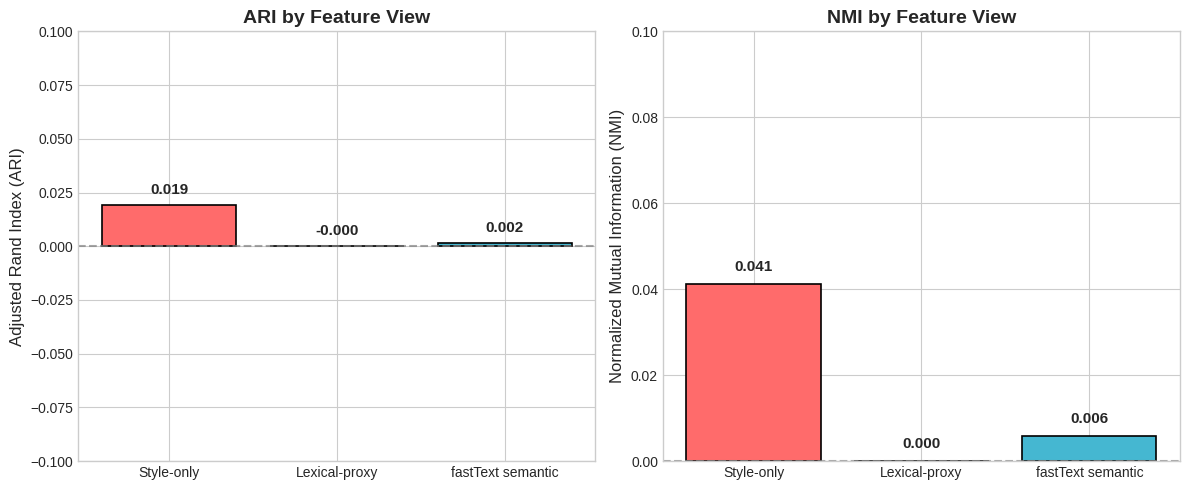

In [ ]:
# Plot ARI and NMI comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ARI Bar Chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0].bar(results_df['Feature View'], results_df['ARI'], color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Adjusted Rand Index (ARI)', fontsize=12)
axes[0].set_title('ARI by Feature View', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.7)
axes[0].set_ylim(-0.1, max(0.1, max(results_df['ARI']) + 0.05))
for i, v in enumerate(results_df['ARI']):
    axes[0].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

# NMI Bar Chart
axes[1].bar(results_df['Feature View'], results_df['NMI'], color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('Normalized Mutual Information (NMI)', fontsize=12)
axes[1].set_title('NMI by Feature View', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.7)
axes[1].set_ylim(0, max(0.1, max(results_df['NMI']) + 0.05))
for i, v in enumerate(results_df['NMI']):
    axes[1].text(i, v + 0.003, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('proxy_audit_metrics.png', dpi=150, bbox_inches='tight')
plt.show()


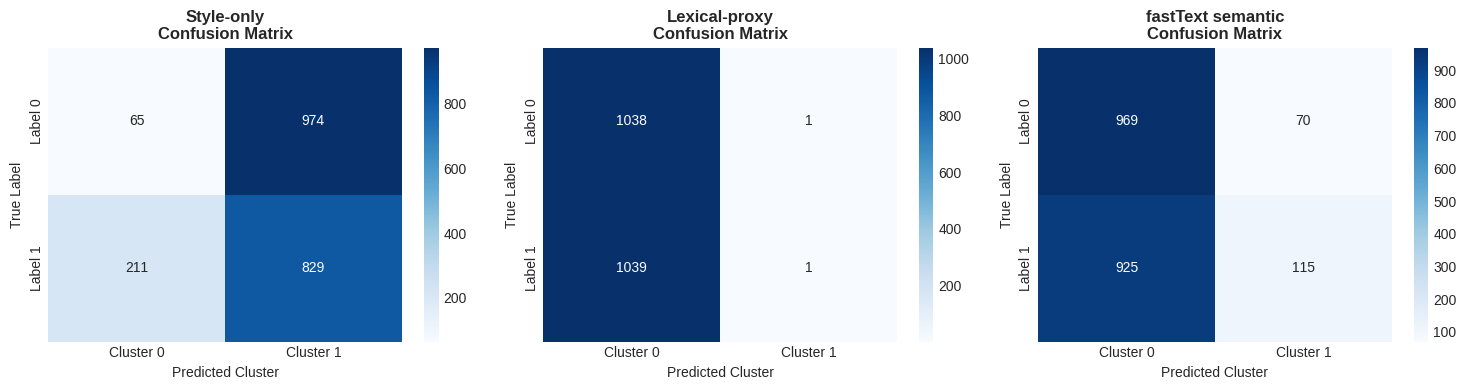

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cms = [cm_style, cm_lex, cm_ft]
titles = ['Style-only', 'Lexical-proxy', 'fastText semantic']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
                yticklabels=[f'Label {i}' for i in range(cm.shape[0])])
    ax.set_title(f'{title}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Cluster')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()


## 12. Qualitative Examples


In [ ]:
def print_cluster_examples(df, cluster_col, label_col, text_col, num_clusters, n_examples=3):
    """Print example texts per cluster and label."""
    print(f'\n{"="*60}')
    print(f'Qualitative Examples by Cluster ({cluster_col})')
    print('='*60)

    for c_id in range(num_clusters):
        subset = df[df[cluster_col] == c_id]
        print(f'\n--- Cluster {c_id} (size={len(subset)}) ---')

        for label_value in sorted(subset[label_col].unique()):
            print(f'  Label = {label_value}')
            sub_lab = subset[subset[label_col] == label_value]

            for _, row in sub_lab.head(n_examples).iterrows():
                txt = row[text_col].replace('\n', ' ')
                if len(txt) > 150:
                    txt = txt[:147] + '...'
                print(f'    - {txt}')


In [ ]:
# Print examples for Style-only clustering
print_cluster_examples(df, 'cluster_style', cfg.label_col, cfg.text_col, num_labels, n_examples=2)



Qualitative Examples by Cluster (cluster_style)

--- Cluster 0 (size=276) ---
  Label = 0
    - A lot of people can relate to this experience. I once had a friend who really enjoyed learning about different cultures, including the food, dance,...
    - Leave your master’s degree on your resume. Your qualifications are strong, and we can focus on finding employers who value your education and exper...
  Label = 1
    - HI! Could you please follow us and help us get the word out about our tumblr? API Collegiate Press is a collaboration between API presses from UC B...
    - I'm male, and am asking this question to non-binary identified people. Why do you give so much of a crap? Why can't you just lighten up, let the th...

--- Cluster 1 (size=1803) ---
  Label = 0
    - Women and men are equally capable and intelligent.
    - People should be free to express themselves and dress however they feel comfortable, regardless of their gender or sexual orientation.
  Label = 1
    - At least, 

In [ ]:
# Print examples for Lexical-proxy clustering
print_cluster_examples(df, 'cluster_lex', cfg.label_col, cfg.text_col, num_labels, n_examples=2)



Qualitative Examples by Cluster (cluster_lex)

--- Cluster 0 (size=2077) ---
  Label = 0
    - Women and men are equally capable and intelligent.
    - People should be free to express themselves and dress however they feel comfortable, regardless of their gender or sexual orientation.
  Label = 1
    - At least, this time, Muslims are not privileged.
    - You don't want to buy a house, it's too much trouble.

--- Cluster 1 (size=2) ---
  Label = 0
    - I see racism and sexism as comparable issues in my experience.
  Label = 1
    - So, which one of your parents is Arab and which one is Jewish?


In [ ]:
# Print examples for fastText clustering
print_cluster_examples(df, 'cluster_ft', cfg.label_col, cfg.text_col, num_labels, n_examples=2)


## 13. Summary and Interpretation


In [ ]:
from IPython.display import Markdown, display

summary_md = f"""
# Proxy Audit Results Summary

## Dataset
- **Split used:** {cfg.split}
- **Total examples:** {len(df):,}
- **Unique labels:** {num_labels}

## Clustering Metrics

| Feature View | ARI | NMI |
|--------------|-----|-----|
| Style-only | {ari_style:.3f} | {nmi_style:.3f} |
| Lexical-proxy | {ari_lex:.3f} | {nmi_lex:.3f} |
| fastText semantic | {ari_ft:.3f} | {nmi_ft:.3f} |

> **ARI** = Adjusted Rand Index (range: -1 to 1)
> **NMI** = Normalized Mutual Information (range: 0 to 1)

## Key Findings

1. **All clustering methods show near-zero alignment with gold labels**
   - ARI values close to 0 indicate cluster assignments are essentially random

2. **Labels are NOT recoverable from superficial proxies**
   - Style features (length, punctuation) do not predict labels
   - Identity term counts do not distinguish microaggressions
   - Even unsupervised semantic embeddings fail to separate classes

3. **Dataset quality indicator**
   - This suggests the labeling is not biased by simple heuristics
   - Annotators did not simply label texts containing identity terms as microaggressions

4. **Implication for modeling**
   - Microaggression detection requires nuanced semantic understanding
   - Supervised learning with contextual embeddings (e.g., BERT) is likely necessary
"""

display(Markdown(summary_md))



# Proxy Audit Results Summary

## Dataset
- **Split used:** train
- **Total examples:** 2,079
- **Unique labels:** 2

## Clustering Metrics

| Feature View | ARI | NMI |
|--------------|-----|-----|
| Style-only | 0.019 | 0.041 |
| Lexical-proxy | -0.000 | 0.000 |
| fastText semantic | 0.002 | 0.006 |

> **ARI** = Adjusted Rand Index (range: -1 to 1)  
> **NMI** = Normalized Mutual Information (range: 0 to 1)

## Key Findings

1. **All clustering methods show near-zero alignment with gold labels**
   - ARI values close to 0 indicate cluster assignments are essentially random

2. **Labels are NOT recoverable from superficial proxies**
   - Style features (length, punctuation) do not predict labels
   - Identity term counts do not distinguish microaggressions
   - Even unsupervised semantic embeddings fail to separate classes

3. **Dataset quality indicator**
   - This suggests the labeling is not biased by simple heuristics
   - Annotators did not simply label texts containing identity terms as microaggressions

4. **Implication for modeling**
   - Microaggression detection requires nuanced semantic understanding
   - Supervised learning with contextual embeddings (e.g., BERT) is likely necessary


In [ ]:
print('\n[INFO] Proxy audit complete!')
print('\nInterpretation tip:')
print('  - If Style-only or Lexical-proxy ARI/NMI are close to fastText,')
print('    labels are highly recoverable from non-semantic proxies.')
print('  - Low scores across all views (as seen here) suggest the dataset')
print('    requires sophisticated understanding to classify correctly.')
